# Unsupervised Learning
#### Dim Reduction
Saw in prev chapter
#### Clustering
Useful in data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dim reduction, etc
#### Anomaly/Outlier Detection
E.g. fraud detection, detect defective product, identify new trends in time series, remove outliers before training another model
#### Density Estimation
Estimates Probability Density Function of the random process that generated the data.
<br>Used for anomaly detection (instances located in very low-density regions are likely to be anomalries), or for data analysis and viz.

# Clustering

#### Customer Segmentation
Cluster them based on purchases and activity.
<br>To understand who customers are and what they need.
<br>Can adapt campaigns to each segment.
<br>Can be used in recommender systems to suggest content other users in the same cluster enjoyed

#### Data Analysis
Analyzing each cluster separately can be helpful

#### Dim Reuction
Can measure each instance's affinity with each cluster (how well it fits)
<br>Feature vector can be replaced by cluster affinities, which can be much lower-dim + preserve enough info

#### Feature Engineering
Cluster affinities as extra features.
<br>E.g. adding geographic cluster affinity to California housing dataset

#### Semi-supervised Learning
Cluster and propagate the labels to instances in same cluster.
<br>Increases the number of labels for subsequent SL algo which improves its performance

#### Search Engines
E.g. Search for images similar to a reference image.
<br>Would need to cluster all images in database, then find the cluster of the reference image.

#### Image Segmentation
Clustering pixels a/c to color and replace its color with the mean color of its cluster
<br>Segmentation is further used in object detection and tracking systems as it becomes easier to detect the contour of each object

## K-Means

In [96]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=5000, cluster_std=[1.5, 1, 1, 2, 1], centers=5, random_state=42)

k=5
km = KMeans(n_clusters=k, random_state=42)
y_pred = km.fit_predict(X)

In [63]:
print(y_pred[:10])
print(y_pred is km.labels_)
print(km.cluster_centers_)

[1 1 0 2 2 0 3 2 4 1]
True
[[  3.31612697   3.07903372]
 [ -2.30370729   9.15485857]
 [ -6.9218021   -6.92852246]
 [ -6.69865449   7.62456545]
 [-10.18553648   7.05630651]]


In [64]:
import numpy as np

X_new = np.array([[0,2], [3,2], [-3,3], [-3, 2.5]])
km.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

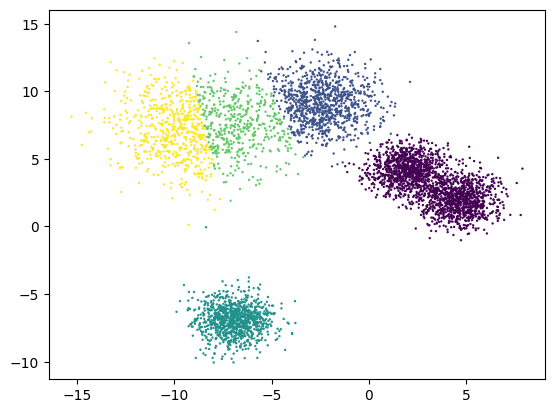

In [65]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=0.5)
plt.show()

K-Means doesn't behave well if blobs have very different diameters cuz it only cares about the distance to the centroid

### Soft Clustering
Instead of hard clustering (assigning each instance to 1 cluster), we can give each instance a score per cluster
<br>Score can be the distance b/w instance and centroid or similarity score/affinity such as Gaussian Radial Basis function

In [56]:
km.transform(X_new).round(2)

array([[13.36,  8.83, 10.59,  5.05,  7.88],
       [15.02, 11.6 ,  8.21,  8.04,  9.06],
       [13.19,  6.96, 13.68,  2.13,  8.74],
       [12.7 ,  6.62, 13.44,  2.04,  8.25]])

Complexity is linear w.r.t m, k and n.
<br>This is true only when data has a clustering structure, otherwise complexity can increase exponentially in the worse-case
<br>But this rarely happens in practice, and K-Means is one of the fastest clustering algos

### Centroid Initialization

We can give initial cluster centers to use (e.g. if we ran some other clustering algo).

In [66]:
good_init = km.cluster_centers_
km = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
km.fit(X)

KMeans(init=array([[  3.31612697,   3.07903372],
       [ -2.30370729,   9.15485857],
       [ -6.9218021 ,  -6.92852246],
       [ -6.69865449,   7.62456545],
       [-10.18553648,   7.05630651]]),
       n_clusters=5, n_init=1, random_state=42)

We can run the algo multiple times with random inits and keep the best solution.
In sklearn, "best" is determined by model's <b>inertia</b> (sum of squared distance b/w instance and closest centroid)

In [68]:
# n_init controls number of inits
# it's 10 by default
km = KMeans(n_clusters=5, n_init=10, random_state=42)
km.fit(X)
# score is -ve of inertia cuz score() must satisfy sklearn's "greater is better" rule
km.inertia_, km.score(X)

(17712.358628005495, -17712.358628005495)

#### K-Means++
- take 1 centroid c(1) chosen uniformly at random from dataset
- take new centroid c(i), choosing instance x(i) with proba:
  - D(x(i))<sup>2</sup> / sum<sub>j=1 to m</sub>(D(x(j))<sup>2</sup>)
  - D(x(i)) is distance b/w x(i) and closest centroid that was already chosen
  - This proba dst ensures instances far away from chosen centroids are more likely to be selected as centroids
- Repeat untill a k centroids have been chosen

sklearn's `KMeans` uses this init method by default

#### Accelerated K-Means
On large datasets with many clusters, we can avoid unnecessary distance calculations.
<br>It uses triangle inequality (straight line always shortest) and by keeping track of lower and upper bounds for distances
<br>This doesn't always accelerate training (depends on dataset)
<br>To use it, set `algorithm="elkan"`

#### Mini-Batch K-Means
Speed up + possible to cluster datasets that don't fit in memory
<br>Roughly 3-5 times faster but with slightly worse inertia

In [69]:
from sklearn.cluster import MiniBatchKMeans

mb_km = MiniBatchKMeans(n_clusters=5, random_state=42)
# can use memory map or partial_fit() like in previous chapter
# partial_fit() requires more work, since need to perform multiple inits and select the best one
mb_km.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

### Finding Optimal Number of Clusters
Inertia isn't good for this task
  - k=3, 653.2
  - k=5, 211.6
  - k=8, 119.1
<br> => it keeps getting lower as we increase k

We can plot inertia against k and check for the inflection point (elbow)

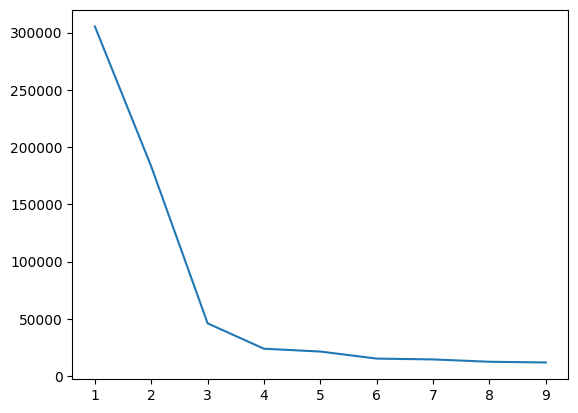

In [70]:
inertias = []
for k in range(1, 10):
    km_i = KMeans(n_clusters=k, random_state=42)
    km_i.fit(X)
    inertias.append(km_i.inertia_)

plt.plot(list(range(1, 10)), inertias)

Above method is rather coarse.
<br>A more precise (and expensive) approach is to use <b>silhouette score</b>
<br>It is the mean <b>silhouette coefficient</b> over all instances
<br>Silhouette coefficient = (b-a) / max(a,b)
  - a is intra-cluster distance
  - b is distance to other instances in nearest cluster
<br>This score varies b/w +1 and -1
  - +1 means instance is well inside its cluster
  - ~0 means instance is close to a cluster boundary
  - -1 means instance may be assigned to wrong cluster

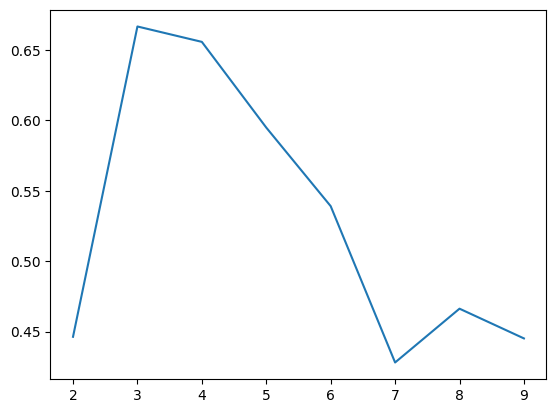

In [73]:
from sklearn.metrics import silhouette_score

sc = []
# must start from at least 2 labels
for k in range(2, 10):
    km_i = KMeans(n_clusters=k, random_state=42)
    km_i.fit(X)
    sc.append(silhouette_score(X, km_i.labels_))

plt.plot(list(range(2, 10)), sc)

A/c to this, k=3 or 4 are good
<br>k=5 and 6 are much better than k=7

#### Silhouette Diagram
Plot every instance's silhouette coefficient, sorted by the clusters they're assigned to and by value of coefficient

<br>Each diagram contains 1 knife shape per cluster
<br>Height indicates number of instances
<br>Width represents sorted silhouette coefficients (wider is better)

We can see how many instances are above the mean coefficient for a cluster for each k.
<br>We can also see which k gives cluster of similar sizes

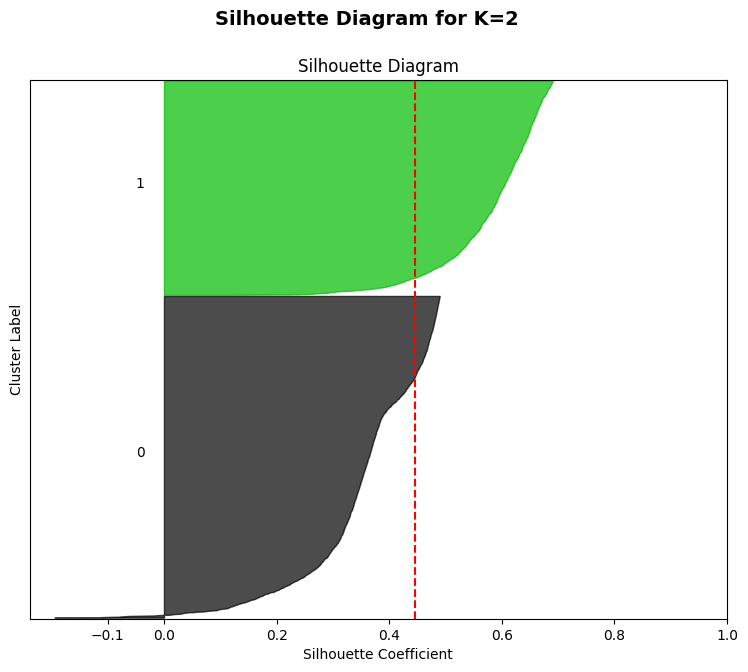

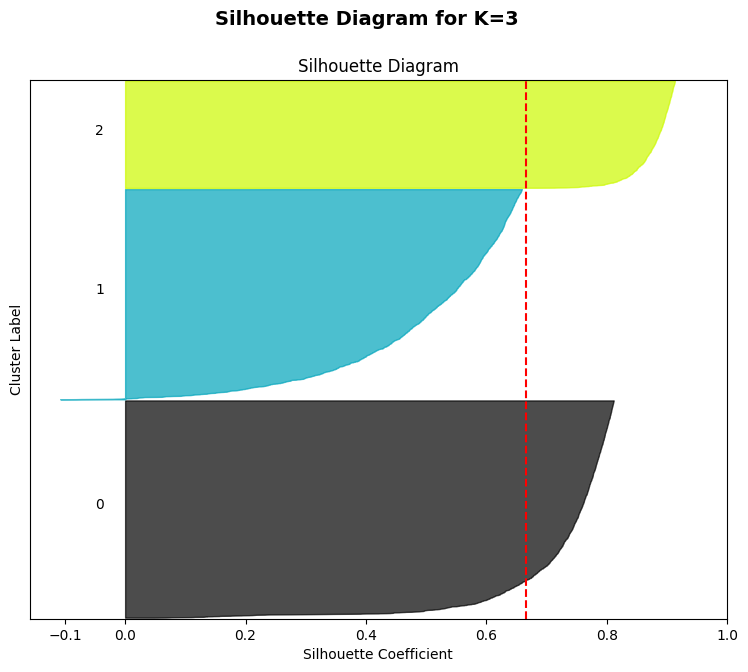

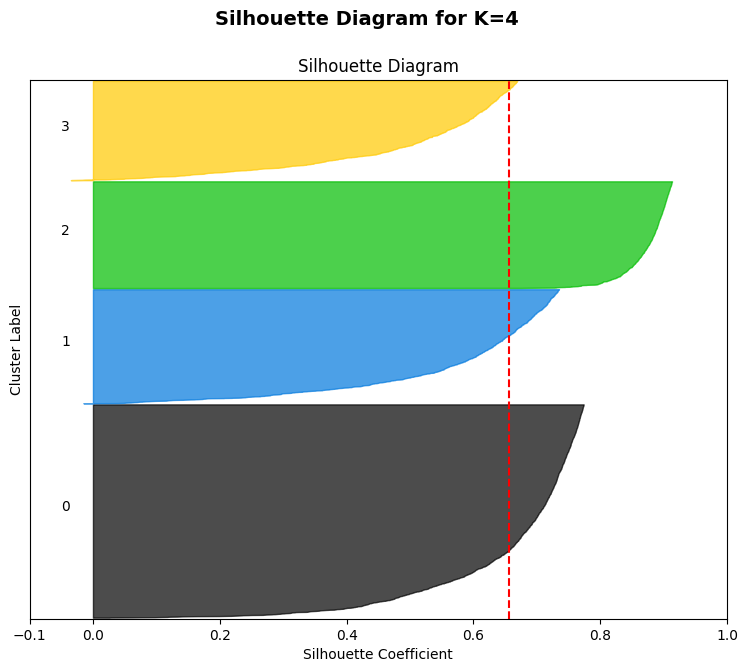

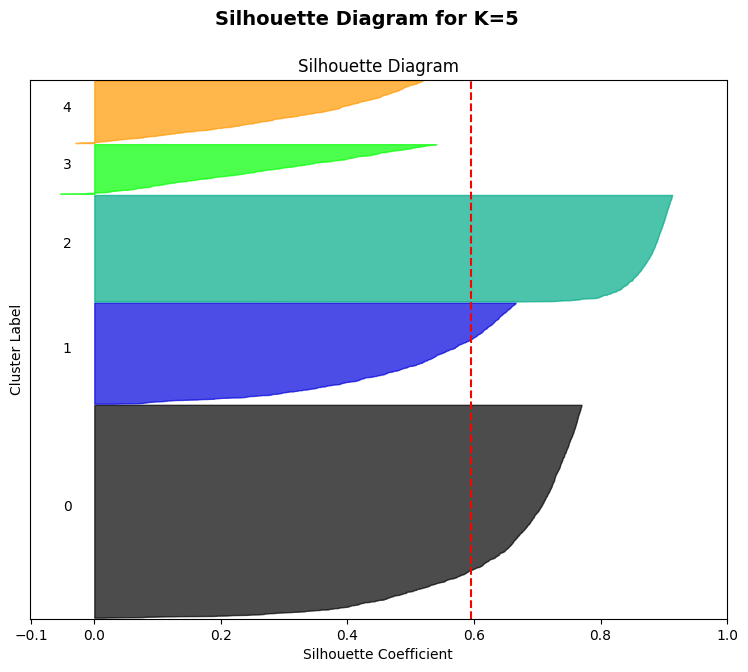

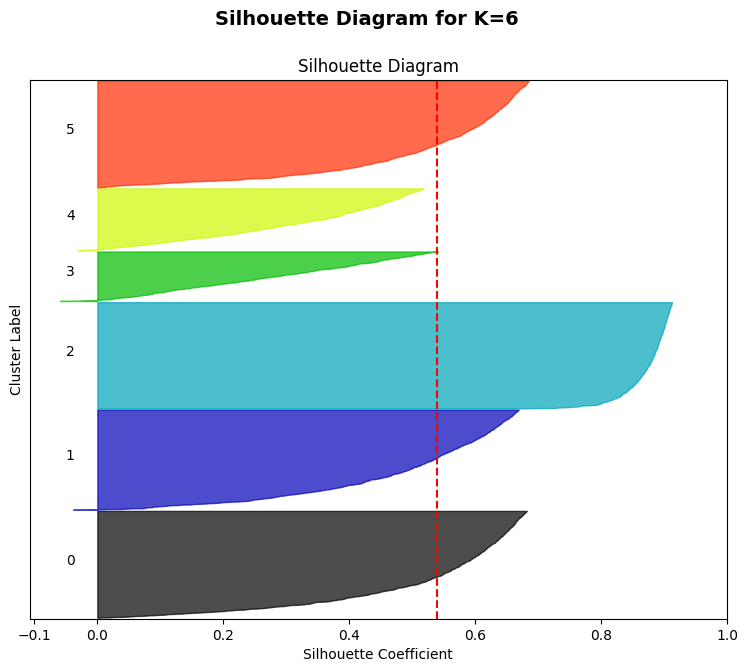

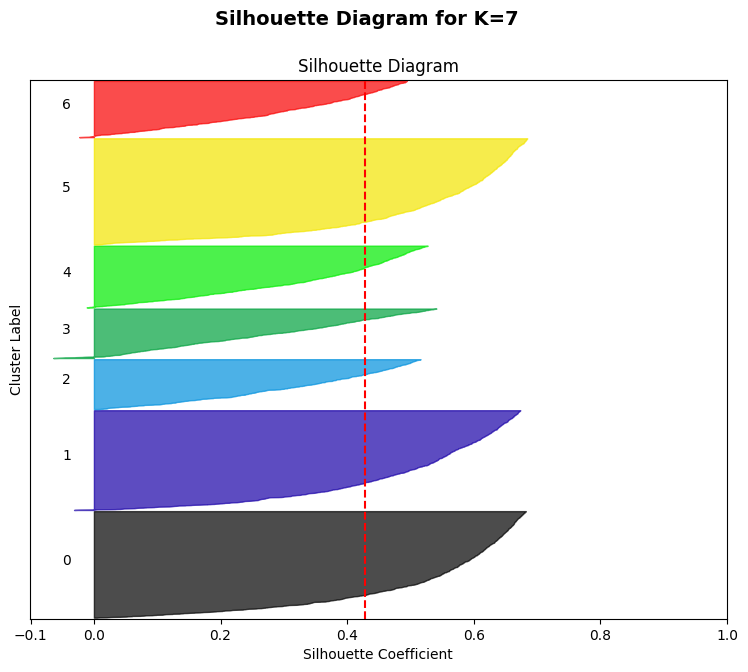

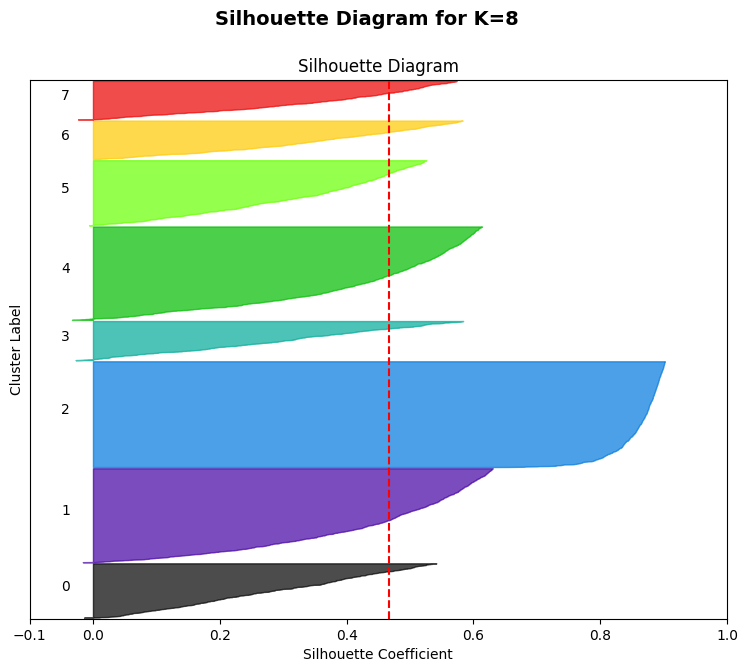

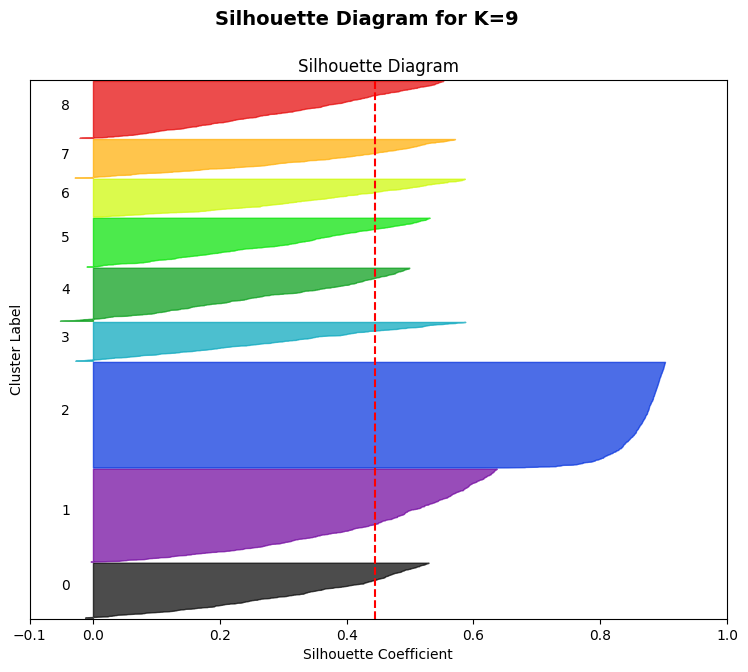

In [120]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


for k in range(2, 10):
    f, ax = plt.subplots(1, 1)
    f.set_size_inches(9, 7)

    # separate clusters more clearly
    ax.set_ylim([0, len(X) + (k + 1)*10])

    km_i = KMeans(n_clusters=k, random_state=42)
    km_labels = km_i.fit_predict(X)
    
    sil_avg = silhouette_score(X, km_labels)
    sample_sil_values = silhouette_samples(X, km_labels)

    y_lower = 10
    for i in range(k):
        cluster_sil_values = sample_sil_values[km_labels == i]
        cluster_sil_values.sort()

        cluster_size = cluster_sil_values.shape[0]
        y_upper = y_lower + cluster_size

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_sil_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        # label the cluster number, put it at middle
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))

        y_lower = y_upper + 10
    
    ax.set_title("Silhouette Diagram")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")

    # vertical line for the avg score
    ax.axvline(x=sil_avg, color='red', linestyle='--')
    
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(f"Silhouette Diagram for K={k}", fontsize=14, fontweight='bold')

plt.show()

#### Feature Scaling
Scaling the features helps k-means.
<br>Doesn't guarantee that clusters will be nice and spherical.

### Clustering for Image Segmentation

In [121]:
import PIL

img = np.asarray(PIL.Image.open("ladybug.png"))
img.shape

(153, 237, 4)

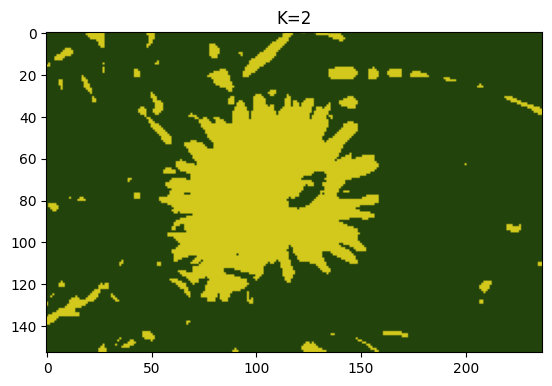

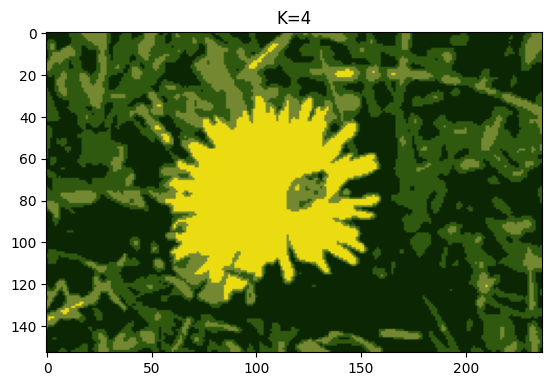

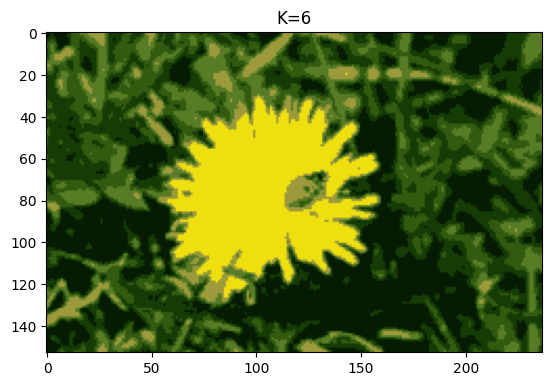

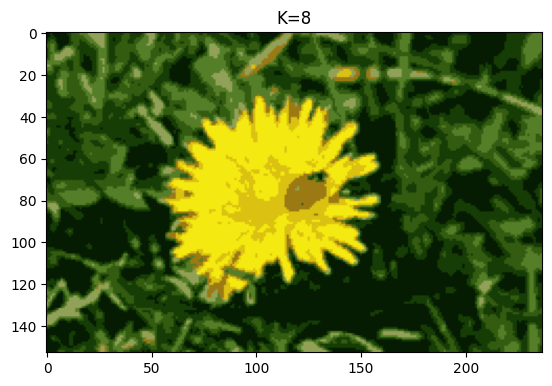

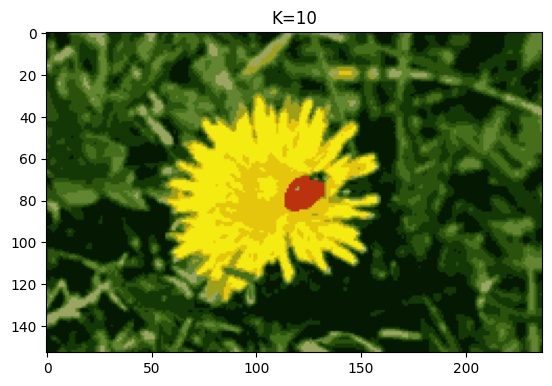

In [131]:
X = img.reshape(-1, 4)

# with k < 8, ladybug's red color doesn't get its own cluster
# cuz K-Means prefers similar size clusters and ladybug is much smaller than the image
for k in range(2, 11, 2):
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    segm_img = km.cluster_centers_[km.labels_]
    segm_img = segm_img.reshape(img.shape)
    segm_img = segm_img[:, :, :3]
    segm_img = segm_img.astype(np.int32)
    
    f, a = plt.subplots(1,1)
    a.imshow(segm_img)
    a.set_title(f'K={k}')

plt.show()

### Clustering for Semi-Supervised Learning

First train a SL algo on 50 instances to compare its performance later.

In [133]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression

X_dgt, y_dgt = load_digits(return_X_y=True)
X_tr, y_tr = X_dgt[:1400], y_dgt[:1400]
X_ts, y_ts = X_dgt[1400:], y_dgt[1400:]

# assume we had only 50 labelled instances
# train a LogisticRegression model to compare with Semi-Supervised approach
n_labeled = 50
lr = LogisticRegression(max_iter=10_000)
lr.fit(X_tr[:n_labeled], y_tr[:n_labeled])

lr.score(X_ts, y_ts)

0.7581863979848866

Find 50 representative images in the dataset

In [152]:
k = 50
km = KMeans(n_clusters=k, random_state=42)
X_dgt_dist = km.fit_transform(X_tr)
representative_dgt_idx = np.argmin(X_dgt_dist, axis=0)
X_representative_dgts = X_tr[representative_dgt_idx]

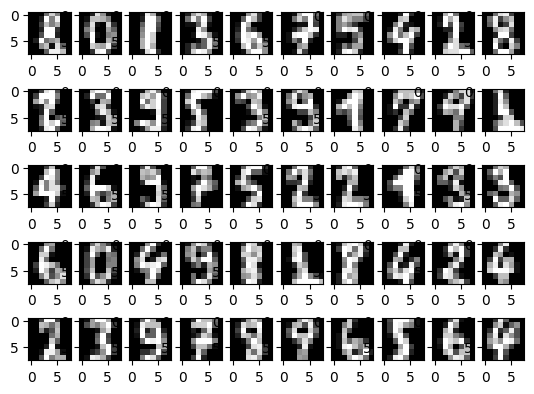

In [157]:
f = plt.figure()
for i, dgt in enumerate(X_representative_dgts):
    dgt = dgt.reshape(8,8)
    
    a = f.add_subplot(5,10,i+1)
    a.imshow(dgt)
plt.show()

Label them manually, then use this labelled dataset to see if SL algo's performance has improved.

In [158]:
# manually label the 50 representative digits
y_rep_dgts = np.array([8, 0, 1, 3, 6, 7, 5, 4, 2, 8,
                       2, 3, 9, 5, 3, 9, 1, 7, 9, 1,
                       4, 6, 9, 7, 5, 2, 2, 1, 3, 3,
                       6, 0, 4, 9, 8, 1, 8, 4, 2, 4,
                       2, 3, 9, 7, 8, 9, 6, 5, 6, 4])

lr = LogisticRegression(max_iter=10_000)
lr.fit(X_representative_dgts, y_rep_dgts)
lr.score(X_ts, y_ts)

0.8312342569269522

#### Label Propagation

In [160]:
y_tr_propa = np.empty(len(X_tr), dtype=np.int64)
for i in range(k):
    y_tr_propa[km.labels_ == i] = y_rep_dgts[i]

Now training SL algo on the dataset after propagating the labels to all instances

In [161]:
lr = LogisticRegression()
lr.fit(X_tr, y_tr_propa)
lr.score(X_ts, y_ts)

c:\dev\miniconda\envs\homl-learn\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8664987405541562

Eliminate some outliers by ignoring instances that are farthest from their cluster

In [162]:
percentile_closest = 99

# get the clusters
X_cluster_dist = X_dgt_dist[np.arange(len(X_tr)), km.labels_]
for i in range(k):
    in_cluster = (km.labels_ == i)
    cl_dist = X_cluster_dist[in_cluster]
    
    cutoff_dist = np.percentile(cl_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_dist)
    
    # mark then as -1 so we ignore them below
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propa = (X_cluster_dist != -1)
X_tr_partially_propa = X_tr[partially_propa]
y_tr_partially_propa = y_tr_propa[partially_propa]

In [163]:
lr = LogisticRegression(max_iter=10_000)
lr.fit(X_tr_partially_propa, y_tr_partially_propa)
lr.score(X_ts, y_ts)

0.8614609571788413

In [168]:
# check accuracy of propagated labels
(y_tr_partially_propa == y_tr[y_tr_partially_propa]).mean()

np.float64(1.0)

#### Using Sklearn
In sklearn.semi_supervised:
- `LabelSpreading`
- `LabelPropagation`
<br>Both construct a similarity matrix b/w all instances and iteratively propagate the labels.

- `SelfTrainingClassifier`
<br>Give it a base clf and it trains it on the labeled instances, then uses it to predict unlabeled samples
<br>It then updates training set with labels it is most confident about and repeats the process until it can't add anymore labels

## DBSCAN
Density-Based Spatial Clustering of Applications with Noise
<br>Defines clusters as continuous regions of high density

Working:
- Count how many instances are located within eps from each instance
  - this region is called eps-neighborhood
- Instances with at least min_samples in its neighborhood (incl itself) are considered core instances
  - core instances are those located in dense regions
- Instances in neighborhood of core instance belong to same cluster
  - This includes other core instances, so a long sequence of neighboring core instances forms 1 cluster
- Any instance that is not a core instance and doesnn't have a core instance in its neighborhood is considered an anomaly

In [170]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [172]:
dbscan.labels_

array([ 3,  0,  0,  1,  2, -1,  0,  2, -1, -1,  0,  0, -1,  0,  2,  0,  0,
        1,  0,  3,  0, -1,  1, -1,  1,  0,  0,  4,  4, -1,  5,  5,  2,  1,
        0,  3,  1,  0,  4,  0,  3,  0,  0,  2,  0,  0,  2,  0,  1,  0,  3,
        6,  3,  1,  0,  6,  0,  7,  0,  2,  3,  0,  5,  3,  6,  0,  2,  2,
       -1,  5,  0,  0,  4,  0,  6,  0,  2,  7,  2,  1,  0,  3,  4,  4,  0,
        1,  2,  2,  0,  0,  0, -1,  2,  1,  2,  0,  0,  0,  0,  1,  2,  0,
       -1,  2,  6,  1,  3,  0,  8,  5,  6,  4,  0,  0, -1,  1,  2,  2,  0,
        3, -1,  0, -1,  1,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0, -1,  0,
        0,  5,  2,  3,  2,  2,  0,  0,  3,  2,  0,  2,  1,  1,  4,  0,  0,
        7,  0,  4,  7,  0, -1,  3,  5,  2,  0,  8, -1,  8,  3,  3,  0,  2,
        1,  2,  7,  0,  0,  0,  7,  6,  0,  0,  3,  0,  0,  0,  2,  5,  5,
        2, -1,  2,  0, -1,  5,  4,  3,  1,  0,  1,  0,  0,  3,  1,  4,  3,
        2,  2,  3,  0,  0, -1,  6,  3,  5,  0,  2,  5,  6,  0,  1, -1,  2,
        2, -1,  0,  3,  3

Some instances above have cluster index of -1 (they're anomalies)

In [173]:
# index of core instances
dbscan.core_sample_indices_

array([  1,   2,   3,   4,   6,   7,  10,  11,  13,  14,  15,  17,  18,
        19,  20,  22,  25,  26,  27,  28,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  42,  43,  44,  46,  47,  48,  50,  51,
        52,  53,  54,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        69,  70,  71,  72,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  85,  86,  87,  88,  89,  90,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 103, 104, 105, 107, 108, 111, 112, 113, 115,
       116, 118, 121, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133,
       135, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 149,
       150, 152, 153, 154, 156, 157, 159, 160, 162, 163, 165, 166, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       183, 185, 186, 187, 190, 192, 193, 194, 196, 197, 198, 199, 202,
       203, 204, 205, 206, 207, 211, 212, 213, 214, 215, 216, 217, 218,
       220, 221, 223, 225, 227, 230, 232, 233, 235, 236, 238, 23

In [174]:
# core instances themselves
dbscan.components_

array([[-0.8913091 ,  0.43110343],
       [-0.98458964,  0.13150948],
       [ 1.17579637, -0.48772583],
       ...,
       [ 1.33983514, -0.50273743],
       [ 2.01458719,  0.2969857 ],
       [ 0.69723384, -0.43529654]])

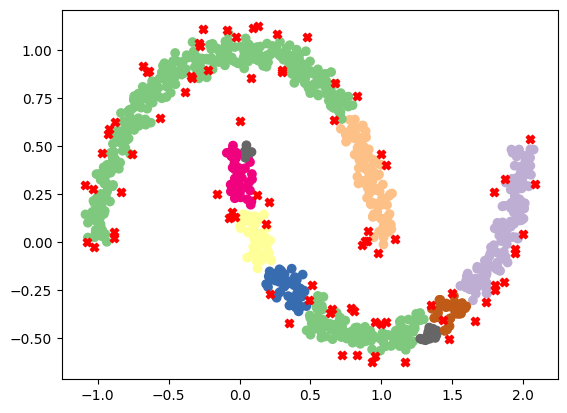

In [186]:
not_anomalies_labels = dbscan.labels_[dbscan.labels_ != -1]
min_idx = not_anomalies_labels.min()
max_idx = not_anomalies_labels.max()
anomalies = X[dbscan.labels_ == -1]
not_anomalies = X[dbscan.labels_ != -1]

plt.scatter(not_anomalies[:, 0], not_anomalies[:, 1], c=(not_anomalies_labels - min_idx)/(max_idx - min_idx), cmap='Accent')
plt.scatter(anomalies[:, 0], anomalies[:, 1], marker='X', c='red')
plt.show()

In [187]:
# try increasing eps
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.2)

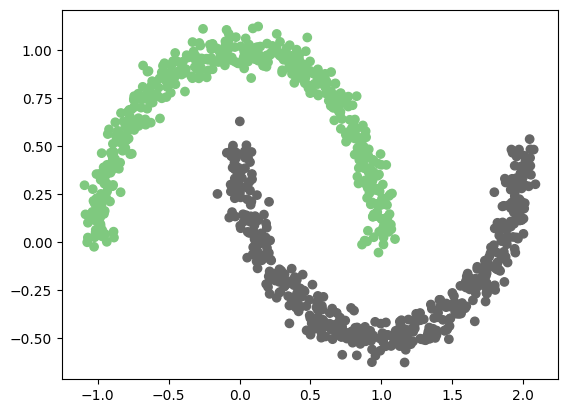

In [189]:
not_anomalies_labels = dbscan.labels_[dbscan.labels_ != -1]
min_idx = not_anomalies_labels.min()
max_idx = not_anomalies_labels.max()
anomalies = X[dbscan.labels_ == -1]
not_anomalies = X[dbscan.labels_ != -1]

plt.scatter(not_anomalies[:, 0], not_anomalies[:, 1], c=(not_anomalies_labels - min_idx)/(max_idx - min_idx), cmap='Accent')
plt.scatter(anomalies[:, 0], anomalies[:, 1], marker='X', c='red')
plt.show()

`DBSCAN` class doesn't have predict(), but it has fit_predict()
<br>This decision was made cuz different clf algos can be better for different tasks
<br>So the user chooses which one to use

In [190]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
# train on core instances
# we can train on all or all except anomalies
# choice depends on task
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [191]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new), knn.predict_proba(X_new)

(array([0, 1, 0, 1]),
 array([[0.8 , 0.2 ],
        [0.  , 1.  ],
        [0.82, 0.18],
        [0.  , 1.  ]]))

Because there's no anomalies in training set, clf always chooses a cluster even if the cluster is far away.
<br>We can introduce a max distance.
<br>`kneighbors()` returns distances and indices of k-nearest neighbors, given an instance.

In [192]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  1,  0, -1])

DBSCAN is robust to outliers and can identify any number of clusters of any shape.
<br>It may fail to capture all clusters if density varies significantly across clusters or there's no sufficiently low-density region around some cluster.
<br>It doesn't scale well as its complexity is O(m<sup>2</sup>n)

## Hierarchical DBSCAN
This is usally better at finding clusters of varying densities.

In [193]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN()
hdbscan.fit(X)

HDBSCAN()

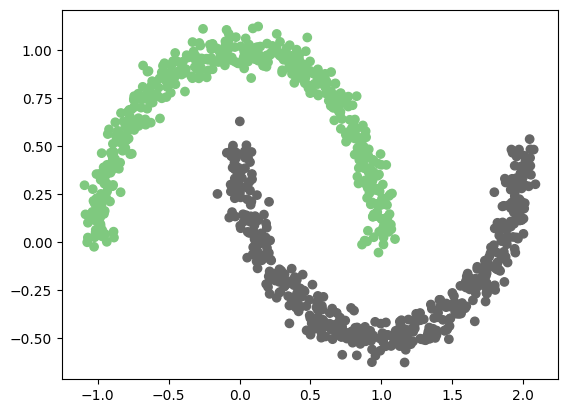

In [195]:
not_anomalies_labels = hdbscan.labels_[hdbscan.labels_ != -1]
min_idx = not_anomalies_labels.min()
max_idx = not_anomalies_labels.max()
anomalies = X[hdbscan.labels_ == -1]
not_anomalies = X[hdbscan.labels_ != -1]

plt.scatter(not_anomalies[:, 0], not_anomalies[:, 1], c=(not_anomalies_labels - min_idx)/(max_idx - min_idx), cmap='Accent')
plt.scatter(anomalies[:, 0], anomalies[:, 1], marker='X', c='red')
plt.show()

## Other Clustering Algos

#### Agglomerative Clustering
  - Hierarchy of clusters if built from bottom-up
  - At each iter, it connects nearest pair of clusters (starting w/ individual instances)
    - Would get a binary tree if drew it for every pair of clusters merged
    - Leaves would be individual instances
  - Captures clusters of various shapes
- Produces flexible, informative cluster tree instead of forcing you to choose a particular cluster scale
- Can be used with any pairwise distance
- Scales well if you provide a connectivity matrix
  - which is a sparse m x m matrix, indicating which instances are neighbors
  - e.g. sklearn.neighbors.kneighbors_graph()
- W/o connectivity matrix, it doesn't scale well

#### BIRCH
 - Balanced Iterative Reducing and Clustering using Hierarchies
 - Designed for very large datasets
   - faster than batch K-Means, with similar results as long as features aren't too large (< 20)
 - Builds a tree structure with just enough info to assign each new instance to a cluster w/o storing all instances in the tree
   - This approach allows it to use limited memory while handling huge datasets

#### Mean-Shift
 - Working
   - Places a circle centered on each instance
   - For each circle, compute mean of all instances within it
   - Shift the circle so it is centered on the meant
   - Iterate until circles stop moving
 - Shifts circles towards higher density until a local density maximum is found
 - Similar features as DBSCAN
   - can find any number of clusters of any shape
   - Has only few hyperparams (only 1, which is the radius of the circles, called bandwidth)
   - Relies on local density estimation
 - Unlike DBSCAN, it chops clusters into pieces when they have internal density variations
 - Complexity is O(m<sup>2</sup>n), so doesn't scale well

#### Affinity Propagation
 - Working
   - Instances exchange info repeatedly until every instance has elected another instance (or itself) to represent it
     - these are called exemplars
   - Each exemplar and those who elected it form 1 cluster
 - Similar to real-life politics
   - you vote for a candidate whose opinions are similar but also want them to win the election so you may choose a candidate you don't fully agree with but is more popular
   - popularity is evaluated through polls
 - Affinity works like this too
   - Tends to choose exemplars located near center of clusters, similar to K-Means
   - Unlike K-Means, don't have to pick a number of clusters
 - Deals with clusters of different sizes
 - Complexity is O(m<sup>2</sup>), so doesn't scale well

#### Spectral Clustering
 - Takes a similarity matrix b/w instances and creates a low-dim embedding from it
 - Then it uses another clustering algo in this low-dim space
   - sklearn's implementation uses K-Means
 - Captures complex clusters
 - Can be used to cut graphs
   - e.g. identify clusters of friends on social network
 - Doesn't scale well
 - Doesn't behave well when clusters have very different sizes

# Gaussian Mixtures

Gaussian Mixture Model (GMM)

Assumes instances were generated from several Gaussian dsts whose params are unknown.
<br>All instances of a single Gaussian dst form an ellipsoid cluster.
  - each cluster can have different ellipsoidal shape, size, density and orientation

There are several GMM variants.
<br>Simplest variant
 - You must know the number "k" of Gaussian dsts.
 - Dataset is assumed to be generated through this process:
   - For each instance, a cluster is picked randomly.
     - Probability of choosing jth cluster is cluster's weight phi(j)
     - Index of cluster chosen for ith instance is z(i)
   - If ith instance was assigned to jth cluster (z(i) = j), then location x(i) of instance is sampled randomly from Gaussian dst with mean u(j) and covariance matrix sigma(j).
     - x(i) ~ N(u(j), sigma(j))

In [220]:
g1 = np.random.normal(loc=-2.0, scale=1.0, size=(500,2))
g2 = np.random.normal(loc=0.0, scale=0.5, size=(500,2))
g3 = np.random.normal(loc=4.0, scale=1.5, size=(250,2))

X = np.vstack((g1, g2, g3))
X.shape

(1250, 2)

Start by estimating weights phi and dst params u and sigma

In [223]:
from sklearn.mixture import GaussianMixture

# n_init is 1 by default
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

It found values close to actual values.
<br>It uses Expectation-Maximization (EM) which has similarities w/ K-Means:
  - Initializes cluster params randomly
  - Repeat 2 steps until convergence:
   - Assign instances to clusters ("expectation step")
   - Update clusters ("maximization step")

Can think of EM as generalization of K-Means, in context of clustering.
 - Not only finds cluster centers (u) but also their shape, size and orientation (sigma), and their relative weights (phi)
<br>Unlike K-Means, it uses soft cluster assignments
  - In expectation step, it estimates proba that instance belongs to each cluster (based on current params)
    - probas are called responsibilities of clusters for the instances
  - In maximization, each cluster is updated using *all* instances
    - Each instance weighted by the estimated proba
    - Each cluster's update is mostly impacted by instances it is most responsible for
  
  Like K-Means, it can converge to poor solutions so it needs to be run several times.

In [224]:
gm.weights_, gm.means_, gm.covariances_

(array([0.40188604, 0.20024289, 0.39787106]),
 array([[-4.54182593e-04,  1.36325988e-02],
        [ 3.91555087e+00,  4.08327930e+00],
        [-2.03121587e+00, -1.93989460e+00]]),
 array([[[ 0.24081073, -0.00730277],
         [-0.00730277,  0.23047883]],
 
        [[ 2.04641931,  0.03905429],
         [ 0.03905429,  2.18042543]],
 
        [[ 1.03103533, -0.05040587],
         [-0.05040587,  1.09324486]]]))

In [225]:
gm.converged_, gm.n_iter_

(True, 6)

After estimating params, it can now estimate proba that given instance belongs to each cluster.

Using `predict()`, we can do hard clustering.

In [226]:
gm.predict(X)

array([2, 2, 2, ..., 1, 1, 1])

Using `predict_proba()`, we can do soft clustering

In [228]:
gm.predict_proba(X).round(3)

array([[0.17, 0.  , 0.83],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       ...,
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  ]])

GMM is a <b>generative model</b>: we can sample new instances

In [229]:
# samples are ordered by cluster index
X_new, y_new = gm.sample(6)

X_new, y_new

(array([[ 0.30767934, -0.55840719],
        [ 0.13338215, -0.1456201 ],
        [ 1.6894379 ,  5.08751001],
        [-3.25978531, -1.73605612],
        [-1.76386572, -1.73871573],
        [-2.83345598, -0.92747782]]),
 array([0, 0, 1, 2, 2, 2]))

We can estimate density at any given location.
<br>This estimates the log of probability density function (PDF)

In [230]:
gm.score_samples(X).round(2)

array([-3.88, -3.83, -3.72, ..., -4.99, -4.45, -5.71])

In [231]:
# this gives proba densities
# they can be any +ve value, cuz they're not probabs
np.exp(gm.score_samples(X))

array([0.02066836, 0.02181188, 0.02416235, ..., 0.00682735, 0.01164042,
       0.00332322])

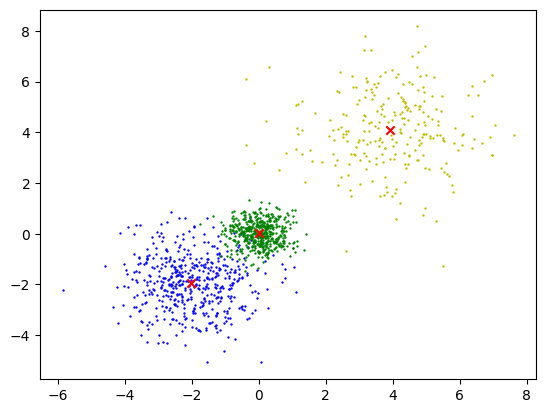

In [244]:
plt.scatter(g1[:, 0], g1[:, 1], s=0.5, color='b')
plt.scatter(g2[:, 0], g2[:, 1], s=0.5, color='g')
plt.scatter(g3[:, 0], g3[:, 1], s=0.5, color='y')
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], marker='x', color='r')
plt.show()

Real-life data is not so low-dim and Gaussian
<br>EM can struggle when there are many dims, many clusters or few instances
<br>We can reduce difficulty by limiting the number of params

1 way is to limit the range of shapes and orientations
<br>This is done by imposing constraints on the covariance matrices
Set `covariance_type` to:
  - spherical
    - all clusters must be spherical, can have different diameters (i.e. variances)
  - diag
    - clusters can be any ellipsoidal shape of any size but its axes must be parallel to coordinate axes (i.e. covariance matrices must be diagonal)
  - tied
    - all clusters must have same ellipsoidal shape, size and orientation (i.e. all have same covariance matrix)
<br>Default value is "full" (unconstrained covariance matrix)

In [249]:
def plot_gm(gm, xrange=(-20.0, 30.0), yrange=(-20.0, 40.0)):
    from matplotlib.colors import LogNorm
    np.random.seed(42)

    x = np.linspace(*xrange)
    y = np.linspace(*yrange)

    X_mg, Y_mg = np.meshgrid(x, y)
    XX = np.array([X_mg.ravel(), Y_mg.ravel()]).T
    Z = -gm.score_samples(XX)
    Z = Z.reshape(X_mg.shape)

    CS = plt.contour(X_mg, Y_mg, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    
    plt.scatter(X[:, 0], X[:, 1], 0.8)

    plt.axis('tight')
    plt.show()

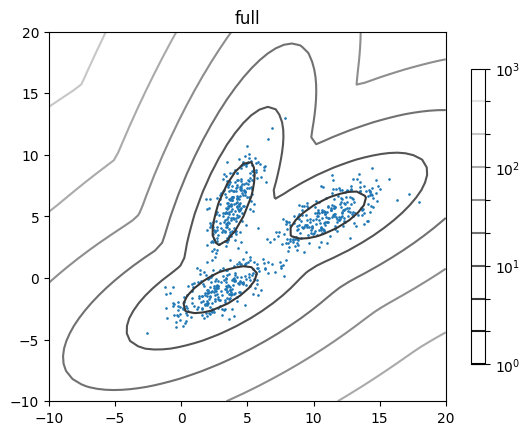

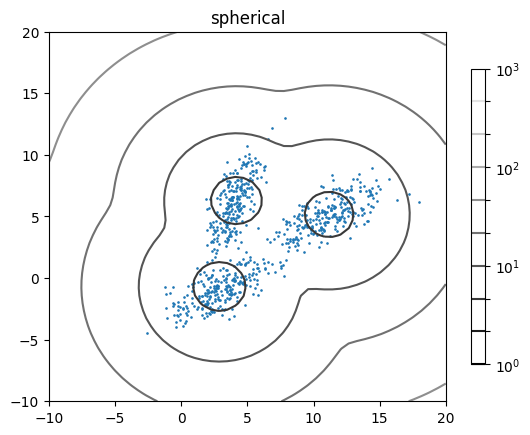

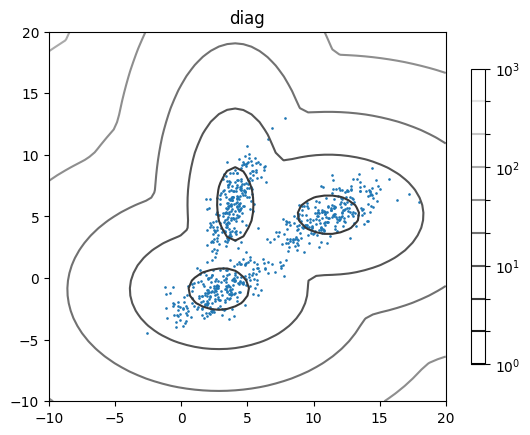

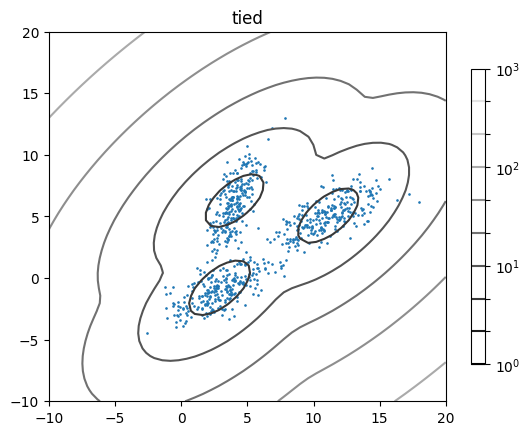

In [284]:
g1 = np.random.normal(loc=-2.0, scale=1.0, size=(500,2))
g2 = np.random.normal(loc=0.0, scale=0.5, size=(500,2))
g3 = np.random.normal(loc=4.0, scale=1.5, size=(250,2))

g1 = np.dot(g3, np.array([[0.5, 0.0], [0.5, 1.5]]))
g2 = np.dot(g3, np.array([[1.0, 0.0], [1.0, 1.0]])) + np.array([[-5, -5]])
g3 = np.dot(g3, np.array([[0.0, -0.7], [1.5, 0.7]])) + np.array([[5, 5]])

X = np.vstack((g1, g2, g3))

for cov_type in ['full', 'spherical', 'diag', 'tied']:
    gm = GaussianMixture(n_components=3, n_init=10, covariance_type=cov_type)
    gm.fit(X)

    plt.title(cov_type)
    plot_gm(gm, xrange=(-10, 20), yrange=(-10, 20))

#### Complexity
If `cov_type` is "spherical" or "diag", O(k * m * n)
<br>if `cov_type` is "tied" or "full", O(k * m * n<sup>2</sup> + k * n<sup>3</sup>)

### GM for Anomaly Deteection
Instances in low-density regions are considered anomalies.

For manufacturing, we can set it to ratio of defective products e.g. 2%.
<br>Can tweak the threshold based on False Positives or False Negatives

Or we can use 4th percentile lowest density (i.e. ~4% of instances will be flagged as anomalies)

In [289]:
densities = gm.score_samples(X)
dens_thresh = np.percentile(densities, 4)
anomalies = X[densities < dens_thresh]

In [291]:
anomalies.shape[0] / X.shape[0] * 100

4.0

Novelty detection is a related task.
<br>But we make the assumption that dataset is clean (no outlier), unlike in Anomaly Detection.
<br>Detecting outliers is often used to clean up a dataset.

GMM fit all data, incl outliers.
<br>This may bias the model's view of normality.
<br>We can fit the model once, use it to detect and remove most extreme outliers, then fit the model again
<br>Or we can use robust covariance estimation methods, e.g. `EllipticEnvelope` class

### Selecting Number of Clusters
Can't use inertia or silhouette score, as they're unreliable when clusters are not spherical or have different sizes.
<br>Instead, we minimize a <b>theoretical info criterion</b>, such as <b>Bayesian info criterion</b> (BIC) or <b>Akaike info criterion</b> (AIC)

BIC = log(m) * p - 2 * log(L)
<br>AIC = 2 * p - 2 * log(L)
Where:
 - m is number of instances
 - p is number of params learned
 - L is maximized value of likelihood function of the model

BIC and AIC penalize models that have more params to learn, and reward models that fit the data well.
<br>They often select the same model, but when they differ, the model selected by BIC tends to be simpler (fewer params) but tends not to fit data quite as well (esp for larger datasets)

Note: Likelihood and probability mean different things
  - Likelihood: how likely a set of params "theta" is, given a sample "x"
  - Proba: what is proba of future outcome "x", given fixed params "theta"
  - Likelihood can be any +ve value as it's not a proba

Given a dataset X, a common task is to maximize likelihood
<br>i.e. find values that maximize the likelihood function (which is a function of theta)
<br>"Maximum Likelihood Estimate" (MLE)

If we know a prior proba dst "g" over theta, we can maximize L(theta|x) * g(theta)
<br>"Maximum a-posteriori estimation" (MAP)
<br>MAP constrains theta, so it's like a regularized version of MLE

Can think of Likelihood function as a measure of how well the model fits the data

In [292]:
gm.bic(X), gm.aic(X)

(np.float64(7167.09961760385), np.float64(7116.278812332016))

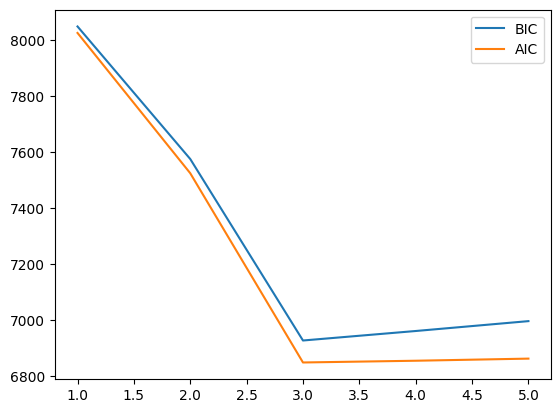

In [301]:
bics = []
aics = []

for k in range(1, 6):
    gm_i = GaussianMixture(n_components=k, n_init=10)
    gm_i.fit(X)
    bics.append(gm_i.bic(X))
    aics.append(gm_i.aic(X))

plt.plot(list(range(1, 6)), bics, label='BIC')
plt.plot(list(range(1, 6)), aics, label='AIC')
plt.legend()
plt.show()

### Bayesian GMM
Capable of giving weights of ~0 to unnecessary clusters, so we don't need to give optimal number of clusters.
<br>We can set `n_components` to a value you have good reason to believe is greater than optimal number of clusters (assumes some minimal knowledge about the problem)

In [302]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

array([0.34, 0.34, 0.33, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

GMM don't do well if clusters have very different shapes.

In [305]:
from sklearn.datasets import make_moons

X, y = make_moons()

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
bgm.weights_.round(2)

array([0.31, 0.23, 0.27, 0.19, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

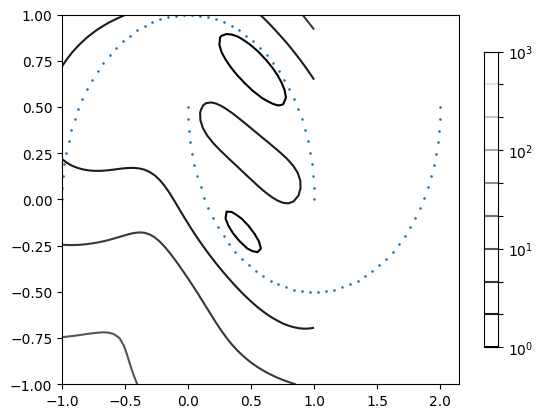

In [308]:
plot_gm(bgm, xrange=(-1, 1), yrange=(-1, 1))

### Other Algos for Anomaly and Novelty Detection

#### Fast-MCD (Minimum Covariance Determinant)
 - Implemented by `EllipticEnvelope`
 - Useful for outlier detection, to clean up a dataset
 - Assumes inliners are generated from 1 Gaussian dst
 - Assumes dataset is contaminated with outliers which weren't generated from this dst
 - When algo estimates params, it's careful to ignore instances that are likely outliers
 - This technique gives better estimation of the elliptic envelope and makes the algo better at identifying outliers

#### Isolation Forest
 - Efficient, esp for high-dim datasets
 - Builds a Random Forest, where each DT is grown randomly
   - at each node, pick a feature randomly
   - then pick a random threshold (b/w min and max values) to split the dataset
   - repeat until all instances are isolated
 - Anomalies are usually far from other instances across all DTs, so they tend to get isolated in fewer steps than normal instances

#### Local Outlier Factor (LOF)
 - Good for outlier detection
 - Compares density of instances around a given instance to density around its neighbors
 - Anomaly is often more isolated than its k-nearest neighbors

#### One-class SVM
 - Better suited for Novely Detection
 - Since we have 1 class, SVM algo separates instances in high-dim space from origin
 - In original space, this corresponds to finding a small region that encompasses all instances
 - If a new instance doesn't fall within this region, it's an anomaly
 - Few hyperparams: usual ones for kernelized SVM + margin hyperparam (proba of new instance being mistakenly considered as novel)
 - Works great, esp w/ hhigh-dim datasets
 - Doesn't scale to large datasets

#### PCA and other dim reduction techniques with inverse_transform() method
 - Reconstruction error of anomaly is usually much larger than that of a normal instance
 - A simple and efficient anomaly detection approach.